In [48]:
import numpy as np
import matplotlib.pyplot as plt

In [67]:
class MLP:
    def __init__(self, input_size, hidden_size, output_size, learning_rate=0.01, epochs=100):
        # Initialize weights and biases with random values between -5 and 5, rounded to 1 decimal
        self.weights_input_hidden = np.round(np.random.uniform(-5, 5, (input_size, hidden_size)), 1)
        self.bias_hidden = np.round(np.random.uniform(-5, 5, hidden_size), 1)
        self.weights_hidden_output = np.round(np.random.uniform(-5, 5, (hidden_size, output_size)), 1)
        self.bias_output = np.round(np.random.uniform(-5, 5, output_size), 1)
        self.learning_rate = learning_rate
        self.epochs = epochs

    def activation(self, x):
        return 1 / (1 + np.exp(-x))

    def activation_derivative(self, x):
        return x * (1 - x)

    def forward(self, x):
        self.hidden_input = np.dot(x, self.weights_input_hidden) + self.bias_hidden
        self.hidden_output = self.activation(self.hidden_input)
        self.final_input = np.dot(self.hidden_output, self.weights_hidden_output) + self.bias_output
        self.final_output = self.activation(self.final_input)
        return self.final_output

    def backward(self, x, y, output):
        output_error = y - output
        output_delta = output_error * self.activation_derivative(output)

        hidden_error = output_delta.dot(self.weights_hidden_output.T)
        hidden_delta = hidden_error * self.activation_derivative(self.hidden_output)

        self.weights_hidden_output += self.hidden_output.T.dot(output_delta) * self.learning_rate
        self.bias_output += np.sum(output_delta, axis=0) * self.learning_rate
        self.weights_input_hidden += x.T.dot(hidden_delta) * self.learning_rate
        self.bias_hidden += np.sum(hidden_delta, axis=0) * self.learning_rate

    def train(self, X, y):
        for epoch in range(self.epochs):
            for i in range(len(X)):
                output = self.forward(X[i].reshape(1, -1))
                self.backward(X[i].reshape(1, -1), y[i].reshape(1, -1), output)

    def predict(self, X):
        outputs = []
        for x in X:
            output = self.forward(x)
            outputs.append(output)
        return np.array(outputs)

In [71]:
class GeneticMLP(MLP):
    def __init__(self, input_size, hidden_size, output_size, population_size=50, generations=100, mutation_rate=0.01):
        super().__init__(input_size, hidden_size, output_size)
        self.population_size = population_size
        self.generations = generations
        self.mutation_rate = mutation_rate
        self.population = self.initialize_population()

    def initialize_population(self):
        return [MLP(input_size=2, hidden_size=2, output_size=1) for _ in range(self.population_size)]

    def fitness(self, mlp, X, y):
        predictions = mlp.predict(X)
        return -np.mean((predictions - y) ** 2)

    def crossover(self, parent1, parent2):
        child = MLP(input_size=2, hidden_size=2, output_size=1)
        for attr in ['weights_input_hidden', 'weights_hidden_output', 'bias_hidden', 'bias_output']:
            child_attr = getattr(child, attr)
            parent1_attr = getattr(parent1, attr)
            parent2_attr = getattr(parent2, attr)
            mask = np.random.rand(*child_attr.shape) < 0.5
            child_attr[mask] = parent1_attr[mask]
            child_attr[~mask] = parent2_attr[~mask]
            setattr(child, attr, child_attr)
        return child

    def mutate(self, mlp):
        for attr in ['weights_input_hidden', 'weights_hidden_output', 'bias_hidden', 'bias_output']:
            attr_val = getattr(mlp, attr)
            mutation_mask = np.random.rand(*attr_val.shape) < self.mutation_rate
            attr_val[mutation_mask] += np.random.uniform(-1, 1, attr_val[mutation_mask].shape)
            setattr(mlp, attr, attr_val)

    def optimize(self, X, y):
        for generation in range(self.generations):
            # Calculate fitness scores for each MLP in the population
            fitness_scores = [self.fitness(mlp, X, y) for mlp in self.population]

            # Sort the population based on fitness scores (higher is better)
            sorted_population = [mlp for _, mlp in sorted(zip(fitness_scores, self.population), key=lambda pair: pair[0], reverse=True)]
            self.population = sorted_population[:self.population_size // 2]

            # Create offspring using crossover and mutation
            offspring = []
            for _ in range(self.population_size // 2):
                parent1, parent2 = np.random.choice(self.population, 2, replace=False)
                child = self.crossover(parent1, parent2)
                self.mutate(child)
                offspring.append(child)

            # Update the population with the new offspring
            self.population += offspring

        # Select the best MLP from the final population
        best_mlp = max(self.population, key=lambda mlp: self.fitness(mlp, X, y))
        self.weights_input_hidden = best_mlp.weights_input_hidden
        self.bias_hidden = best_mlp.bias_hidden
        self.weights_hidden_output = best_mlp.weights_hidden_output
        self.bias_output = best_mlp.bias_output

In [60]:
X = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])

def nand_gate(x1, x2):
    return int(not (x1 and x2))

def xor_gate(x1, x2):
    return int(x1 != x2)

y_nand = np.array([[nand_gate(x[0], x[1])] for x in X])
y_xor = np.array([[xor_gate(x[0], x[1])] for x in X])

In [74]:
def plot_graphs(nand_predictions, xor_predictions, mlp_nand, mlp_xor):
  colors_nand = ['blue' if output >= 0.5 else 'red' for output in nand_predictions.flatten()]
  colors_xor = ['blue' if output >= 0.5 else 'red' for output in xor_predictions.flatten()]

  plt.figure(figsize=(12, 5))

  plt.subplot(1, 2, 1)
  for i, (x1, x2) in enumerate(X):
      plt.scatter(x1, x2, color=colors_nand[i], s=100, label=f'({x1}, {x2}) -> {nand_predictions[i][0]}')

  # Draw lines based on weights for each perceptron in hidden layer (NAND)
  for j in range(mlp_nand.weights_input_hidden.shape[1]):
      w1, w2 = mlp_nand.weights_input_hidden[:, j]
      b = mlp_nand.bias_hidden[j]
      # Calculate x2 for the line equation w1*x1 + w2*x2 + b = 0
      x1_values = np.array([-0.5, 1.5])
      x2_values = (-b - w1 * x1_values) / w2
      plt.plot(x1_values, x2_values, linestyle='--', color='gray')

  plt.title("MLP NAND Gate Output")
  plt.xlabel("x1")
  plt.ylabel("x2")
  plt.xlim(-0.5, 1.5)
  plt.ylim(-0.5, 1.5)
  plt.legend(loc='upper right')

  plt.subplot(1, 2, 2)
  for i, (x1, x2) in enumerate(X):
      plt.scatter(x1, x2, color=colors_xor[i], s=100, label=f'({x1}, {x2}) -> {xor_predictions[i][0]}')

  # Draw lines based on weights for each perceptron in hidden layer (XOR)
  for j in range(mlp_xor.weights_input_hidden.shape[1]):
      w1, w2 = mlp_xor.weights_input_hidden[:, j]
      b = mlp_xor.bias_hidden[j]
      # Calculate x2 for the line equation w1*x1 + w2*x2 + b = 0
      x1_values = np.array([-0.5, 1.5])
      x2_values = (-b - w1 * x1_values) / w2
      plt.plot(x1_values, x2_values, linestyle='--', color='gray')

  plt.title("MLP XOR Gate Output")
  plt.xlabel("x1")
  plt.ylabel("x2")
  plt.xlim(-0.5, 1.5)
  plt.ylim(-0.5, 1.5)
  plt.legend(loc='upper right')

  plt.tight_layout()
  plt.show()

In [75]:
def run(num_epochs=100, learning_rate=0.1):
  print(f'Run for {num_epochs} epochs and learning rate of {learning_rate} : ')
  mlp_nand = MLP(input_size=2, hidden_size=2, output_size=1, learning_rate=learning_rate, epochs=num_epochs)
  mlp_nand.train(X, y_nand)
  nand_predictions = mlp_nand.predict(X)

  mlp_xor = MLP(input_size=2, hidden_size=2, output_size=1, learning_rate=learning_rate, epochs=num_epochs)
  mlp_xor.train(X, y_xor)
  xor_predictions = mlp_xor.predict(X)

  print("Trained weights for NAND gate:")
  print("Input-Hidden Weights:\n", mlp_nand.weights_input_hidden)
  print("Hidden-Output Weights:\n", mlp_nand.weights_hidden_output)

  print("\nTrained weights for XOR gate:")
  print("Input-Hidden Weights:\n", mlp_xor.weights_input_hidden)
  print("Hidden-Output Weights:\n", mlp_xor.weights_hidden_output)

  plot_graphs(nand_predictions, xor_predictions, mlp_nand, mlp_xor)

  print('\n------------------------------------------------------------------')

Run for 100 epochs and learning rate of 0.7 : 
Trained weights for NAND gate:
Input-Hidden Weights:
 [[-3.67576896 -2.247154  ]
 [ 4.88831159  5.01902275]]
Hidden-Output Weights:
 [[-1.91202363]
 [-3.63851651]]

Trained weights for XOR gate:
Input-Hidden Weights:
 [[ 2.49693769 -3.72656933]
 [ 2.35922646 -4.80143327]]
Hidden-Output Weights:
 [[-2.54840349]
 [-2.90580809]]


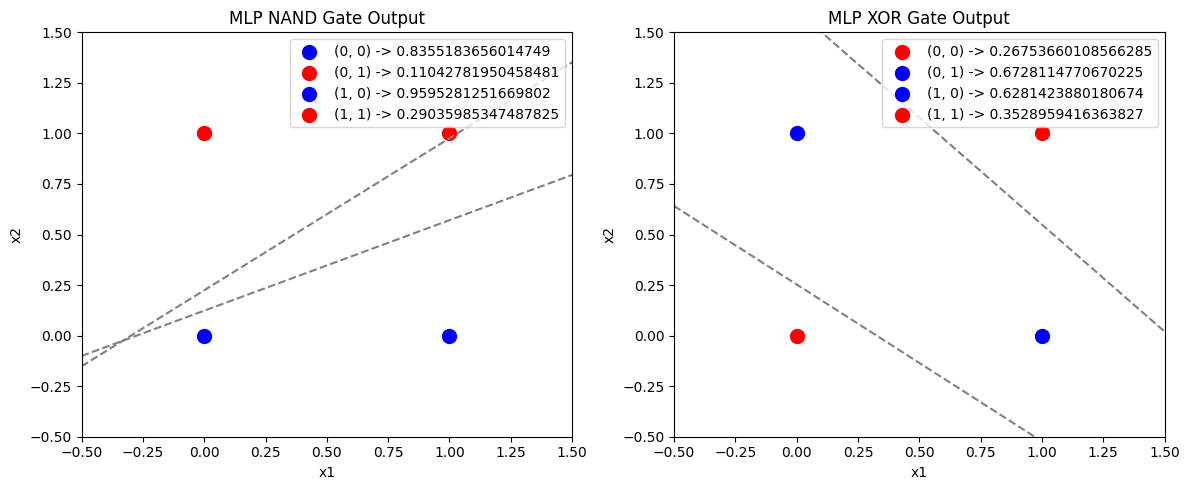


------------------------------------------------------------------
Run for 500 epochs and learning rate of 0.7 : 
Trained weights for NAND gate:
Input-Hidden Weights:
 [[-3.55142845 -0.52555284]
 [ 4.47929902  1.08256769]]
Hidden-Output Weights:
 [[-2.63139902]
 [-0.36404959]]

Trained weights for XOR gate:
Input-Hidden Weights:
 [[-4.26766248  5.40007751]
 [ 0.99873144  5.51535497]]
Hidden-Output Weights:
 [[-3.07180049]
 [ 3.72988883]]


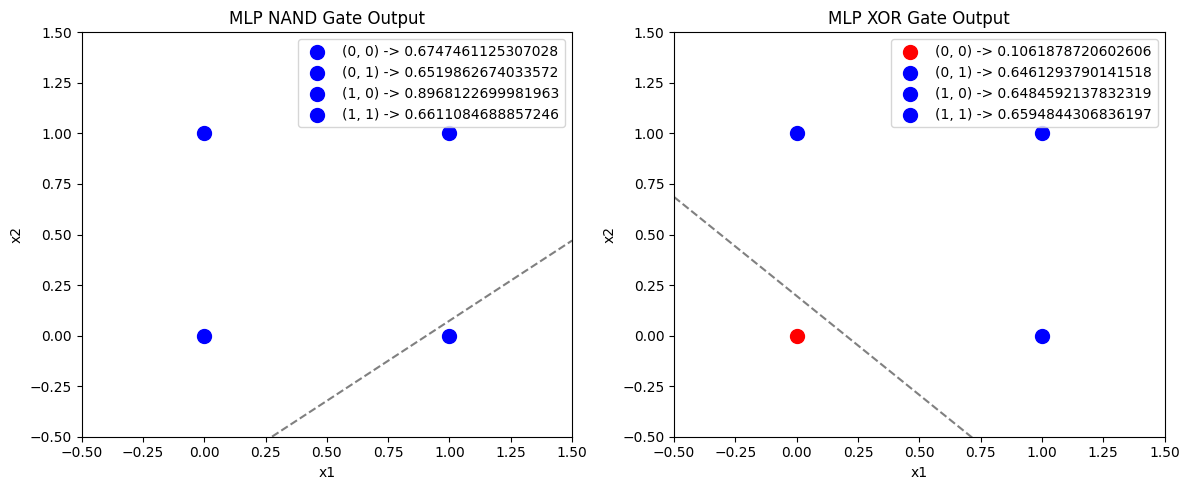


------------------------------------------------------------------
Run for 1000 epochs and learning rate of 0.7 : 
Trained weights for NAND gate:
Input-Hidden Weights:
 [[-3.33387419  1.49664656]
 [-2.21745639  1.1944008 ]]
Hidden-Output Weights:
 [[-1.59132371]
 [-0.17815569]]

Trained weights for XOR gate:
Input-Hidden Weights:
 [[ 4.56602947 -5.07138228]
 [ 4.71315683 -5.48501601]]
Hidden-Output Weights:
 [[-7.29851283]
 [-7.54685082]]


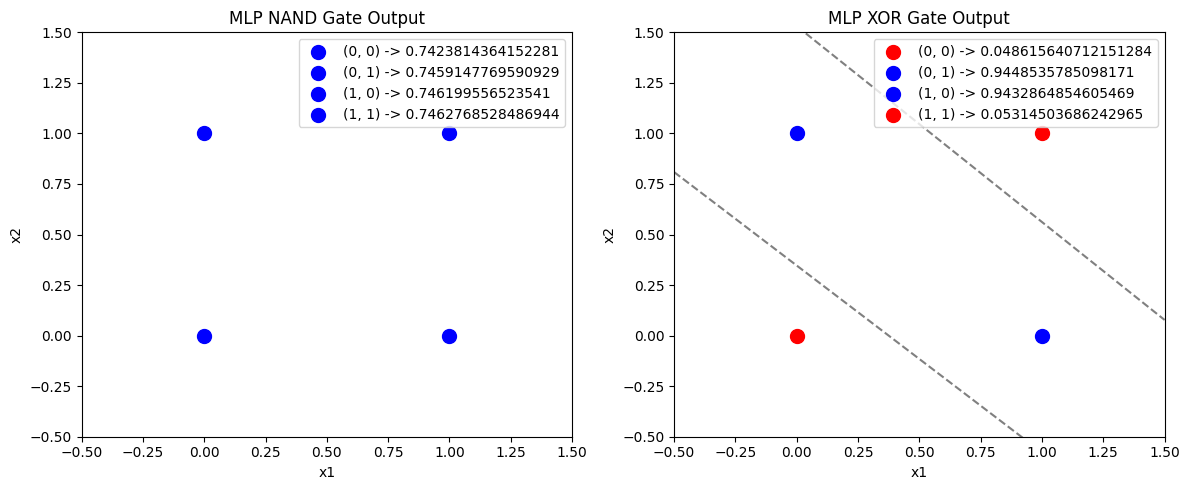


------------------------------------------------------------------
Run for 3000 epochs and learning rate of 0.7 : 
Trained weights for NAND gate:
Input-Hidden Weights:
 [[ 2.33237647 -5.74252333]
 [-6.11178963  0.33456065]]
Hidden-Output Weights:
 [[7.78037601]
 [8.11932848]]

Trained weights for XOR gate:
Input-Hidden Weights:
 [[ 5.34125851 -6.84940976]
 [ 5.35993541 -6.82585055]]
Hidden-Output Weights:
 [[6.86265546]
 [6.50922693]]


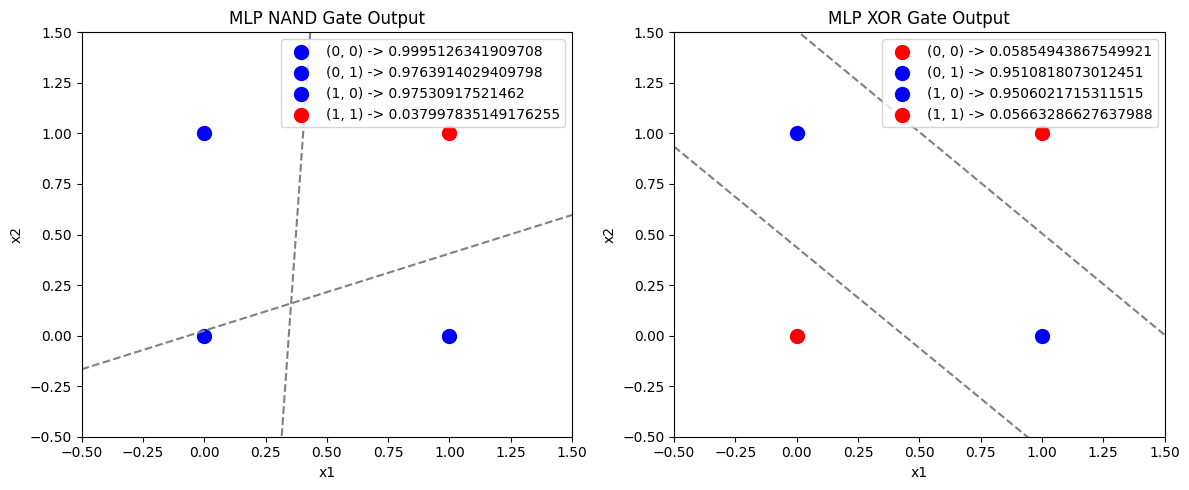


------------------------------------------------------------------
Run for 10000 epochs and learning rate of 0.7 : 
Trained weights for NAND gate:
Input-Hidden Weights:
 [[-7.0855654   4.19474661]
 [ 0.90385138 -6.75688736]]
Hidden-Output Weights:
 [[9.12486696]
 [9.06465745]]

Trained weights for XOR gate:
Input-Hidden Weights:
 [[-6.26262238 -6.08037288]
 [ 6.1033107   5.67927087]]
Hidden-Output Weights:
 [[-9.78448794]
 [10.1249064 ]]


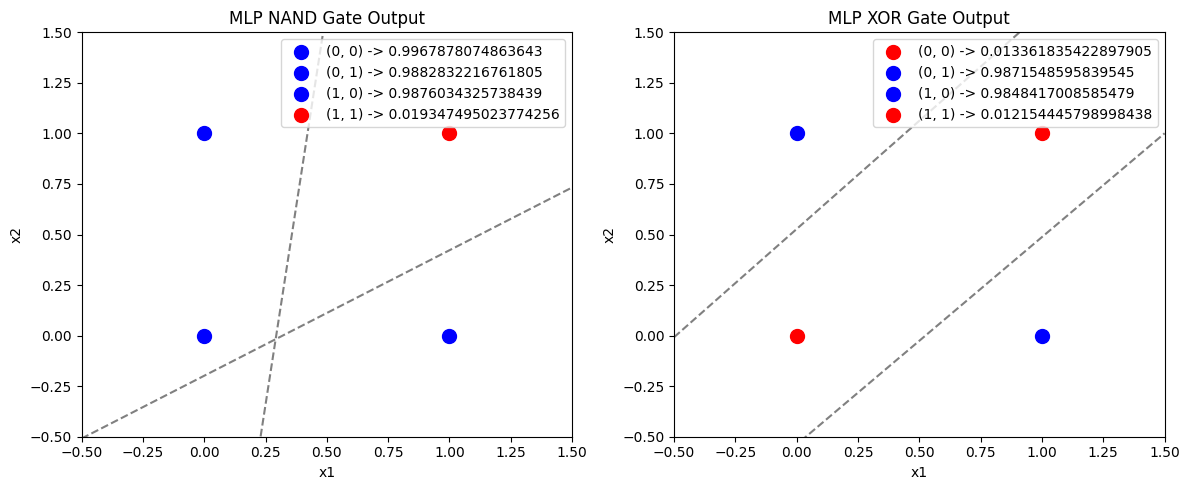


------------------------------------------------------------------


In [95]:
for epochs in [100, 500, 1000, 3000, 10000]:
  run(num_epochs=epochs, learning_rate=0.7)

In [100]:
def plot_graphs_comparison(nand_predictions_bp, nand_predictions_ga, xor_predictions_bp, xor_predictions_ga, mlp_nand_bp, mlp_nand_ga, mlp_xor_bp, mlp_xor_ga):
    colors_nand_bp = ['blue' if output >= 0.5 else 'red' for output in nand_predictions_bp.flatten()]
    colors_nand_ga = ['blue' if output >= 0.5 else 'red' for output in nand_predictions_ga.flatten()]
    colors_xor_bp = ['blue' if output >= 0.5 else 'red' for output in xor_predictions_bp.flatten()]
    colors_xor_ga = ['blue' if output >= 0.5 else 'red' for output in xor_predictions_ga.flatten()]

    plt.figure(figsize=(12, 10))

    plt.subplot(2, 2, 1)
    for i, (x1, x2) in enumerate(X):
        plt.scatter(x1, x2, color=colors_nand_bp[i], s=100, label=f'({x1}, {x2}) -> {nand_predictions_bp[i][0]:.2f}')

    for j in range(mlp_nand_bp.weights_input_hidden.shape[1]):
        w1, w2 = mlp_nand_bp.weights_input_hidden[:, j]
        b = mlp_nand_bp.bias_hidden[j]
        x1_values = np.array([-0.5, 1.5])
        x2_values = (-b - w1 * x1_values) / w2
        plt.plot(x1_values, x2_values, linestyle='--', color='gray')

    plt.title("Backpropagation - NAND Gate")
    plt.xlabel("x1")
    plt.ylabel("x2")
    plt.xlim(-0.5, 1.5)
    plt.ylim(-0.5, 1.5)
    plt.legend(loc='upper right')

    plt.subplot(2, 2, 2)
    for i, (x1, x2) in enumerate(X):
        plt.scatter(x1, x2, color=colors_nand_ga[i], s=100, label=f'({x1}, {x2}) -> {nand_predictions_ga[i][0]:.2f}')

    for j in range(mlp_nand_ga.weights_input_hidden.shape[1]):
        w1, w2 = mlp_nand_ga.weights_input_hidden[:, j]
        b = mlp_nand_ga.bias_hidden[j]
        x1_values = np.array([-0.5, 1.5])
        x2_values = (-b - w1 * x1_values) / w2
        plt.plot(x1_values, x2_values, linestyle='--', color='gray')

    plt.title("Genetic Algorithm - NAND Gate")
    plt.xlabel("x1")
    plt.ylabel("x2")
    plt.xlim(-0.5, 1.5)
    plt.ylim(-0.5, 1.5)
    plt.legend(loc='upper right')

    plt.subplot(2, 2, 3)
    for i, (x1, x2) in enumerate(X):
        plt.scatter(x1, x2, color=colors_xor_bp[i], s=100, label=f'({x1}, {x2}) -> {xor_predictions_bp[i][0]:.2f}')

    for j in range(mlp_xor_bp.weights_input_hidden.shape[1]):
        w1, w2 = mlp_xor_bp.weights_input_hidden[:, j]
        b = mlp_xor_bp.bias_hidden[j]
        x1_values = np.array([-0.5, 1.5])
        x2_values = (-b - w1 * x1_values) / w2
        plt.plot(x1_values, x2_values, linestyle='--', color='gray')

    plt.title("Backpropagation - XOR Gate")
    plt.xlabel("x1")
    plt.ylabel("x2")
    plt.xlim(-0.5, 1.5)
    plt.ylim(-0.5, 1.5)
    plt.legend(loc='upper right')

    plt.subplot(2, 2, 4)
    for i, (x1, x2) in enumerate(X):
        plt.scatter(x1, x2, color=colors_xor_ga[i], s=100, label=f'({x1}, {x2}) -> {xor_predictions_ga[i][0]:.2f}')

    for j in range(mlp_xor_ga.weights_input_hidden.shape[1]):
        w1, w2 = mlp_xor_ga.weights_input_hidden[:, j]
        b = mlp_xor_ga.bias_hidden[j]
        x1_values = np.array([-0.5, 1.5])
        x2_values = (-b - w1 * x1_values) / w2
        plt.plot(x1_values, x2_values, linestyle='--', color='gray')

    plt.title("Genetic Algorithm - XOR Gate")
    plt.xlabel("x1")
    plt.ylabel("x2")
    plt.xlim(-0.5, 1.5)
    plt.ylim(-0.5, 1.5)
    plt.legend(loc='upper right')

    plt.tight_layout()
    plt.show()

In [101]:
def run_comparison(num_epochs=100, learning_rate=0.1, generations=100):
    # Train NAND with Backpropagation
    mlp_nand_bp = MLP(input_size=2, hidden_size=2, output_size=1, learning_rate=learning_rate, epochs=num_epochs)
    mlp_nand_bp.train(X, y_nand)
    nand_predictions_bp = mlp_nand_bp.predict(X)

    print("Trained weights for bp-NAND gate:")
    print("Input-Hidden Weights:\n", mlp_nand_bp.weights_input_hidden)
    print("Hidden-Output Weights:\n", mlp_nand_bp.weights_hidden_output)

    # Train NAND with Genetic Algorithm
    mlp_nand_ga = GeneticMLP(input_size=2, hidden_size=2, output_size=1, generations=generations)
    mlp_nand_ga.optimize(X, y_nand)
    nand_predictions_ga = mlp_nand_ga.predict(X)

    print("\nTrained weights for ga-NAND gate:")
    print("Input-Hidden Weights:\n", mlp_nand_ga.weights_input_hidden)
    print("Hidden-Output Weights:\n", mlp_nand_ga.weights_hidden_output)

    # Train XOR with Backpropagation
    mlp_xor_bp = MLP(input_size=2, hidden_size=2, output_size=1, learning_rate=learning_rate, epochs=num_epochs)
    mlp_xor_bp.train(X, y_xor)
    xor_predictions_bp = mlp_xor_bp.predict(X)

    print("\nTrained weights for bp-XOR gate:")
    print("Input-Hidden Weights:\n", mlp_xor_bp.weights_input_hidden)
    print("Hidden-Output Weights:\n", mlp_xor_bp.weights_hidden_output)

    # Train XOR with Genetic Algorithm
    mlp_xor_ga = GeneticMLP(input_size=2, hidden_size=2, output_size=1, generations=generations)
    mlp_xor_ga.optimize(X, y_xor)
    xor_predictions_ga = mlp_xor_ga.predict(X)

    print("\nTrained weights for ga-XOR gate:")
    print("Input-Hidden Weights:\n", mlp_xor_ga.weights_input_hidden)
    print("Hidden-Output Weights:\n", mlp_xor_ga.weights_hidden_output)

    # Plot the results
    plot_graphs_comparison(nand_predictions_bp, nand_predictions_ga, xor_predictions_bp, xor_predictions_ga,\
                           mlp_nand_bp, mlp_nand_ga, mlp_xor_bp, mlp_xor_ga)


Trained weights for bp-NAND gate:
Input-Hidden Weights:
 [[-4.78362441 -2.24450704]
 [-4.79254923 -4.39159781]]
Hidden-Output Weights:
 [[10.18136952]
 [-2.32208452]]

Trained weights for ga-NAND gate:
Input-Hidden Weights:
 [[3.40537786 3.48213338]
 [3.47139438 3.77154335]]
Hidden-Output Weights:
 [[-26.07309586]
 [-18.6399911 ]]

Trained weights for bp-XOR gate:
Input-Hidden Weights:
 [[ 7.21718769 -5.50609136]
 [ 7.22920604 -5.50701375]]
Hidden-Output Weights:
 [[8.53718515]
 [8.69680814]]

Trained weights for ga-XOR gate:
Input-Hidden Weights:
 [[ 21.90270684  16.23223514]
 [-19.37931984 -18.16063403]]
Hidden-Output Weights:
 [[-28.88409346]
 [ 31.21005616]]


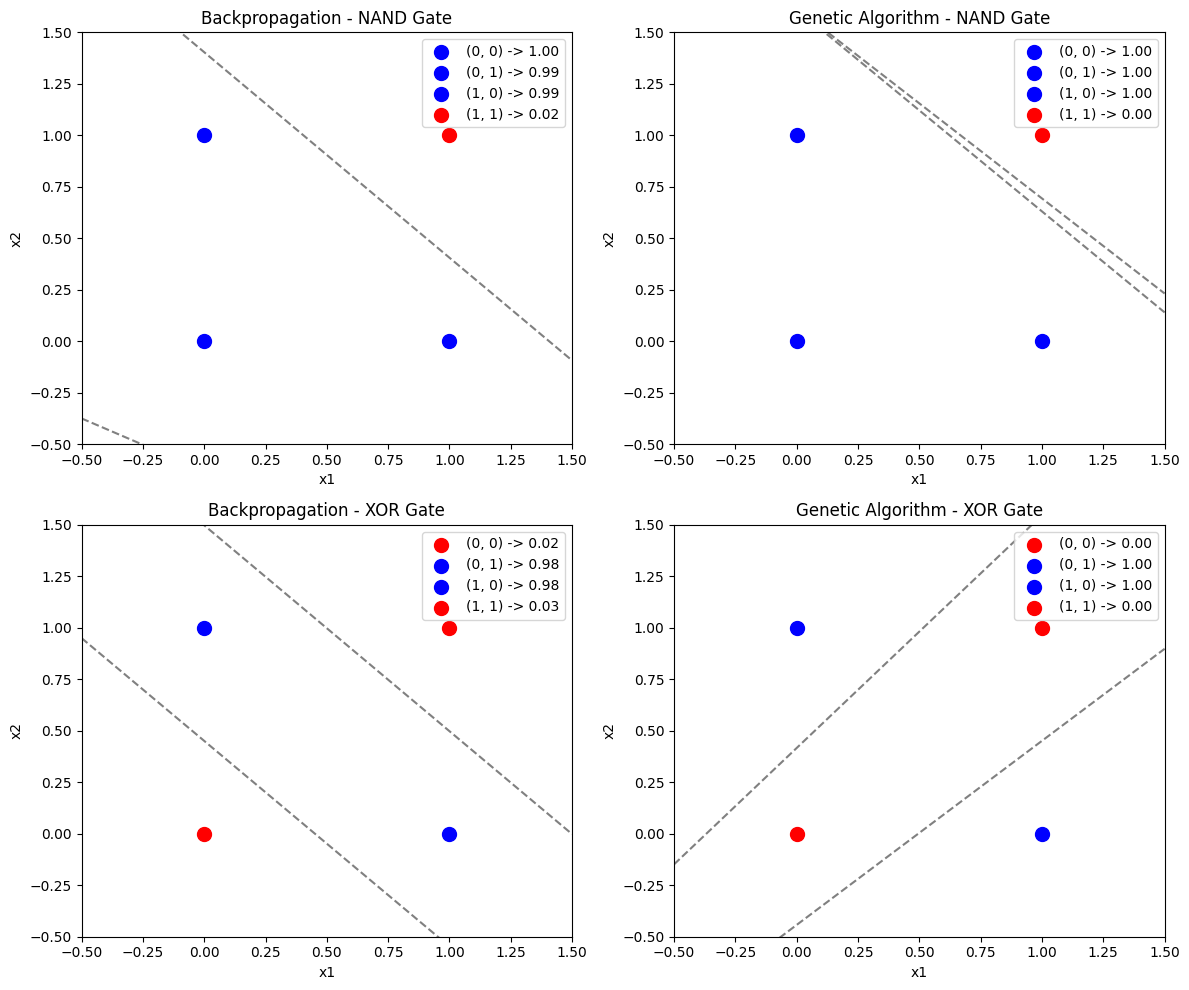

In [108]:
run_comparison(num_epochs=10000, learning_rate=0.5, generations=1000)